In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
from torchvision.io import read_image
from tqdm import tqdm

In [21]:
NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 15
VAL_BATCH_SIZE = 16

TEST_DIR = r"D:\project\dataset\chest_xray\test"
TRAIN_DIR= r"D:\project\dataset\chest_xray\train"
VAL_DIR = r"D:\project\dataset\chest_xray\val"

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256),antialias=True)
    ])

test_dataset = datasets.ImageFolder(root=TEST_DIR,
                          transform=transform)

train_dataset = datasets.ImageFolder(root=TRAIN_DIR,
                          transform=transform)

val_dataset = datasets.ImageFolder(root=VAL_DIR,
                          transform=transform)



# prepare data loaders with batch sizes
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=True)

val_loader = DataLoader(val_dataset, num_workers=NUM_WORKERS, pin_memory=True)   # Full validation data

test_loader = DataLoader(test_dataset, num_workers=NUM_WORKERS, pin_memory=True)  

In [23]:
class_to_idx = train_dataset.class_to_idx
idx_to_class = {idx : label for label, idx in class_to_idx.items()}

idx_to_class

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class attention_unet(nn.Module):
    def __init__(self):
        super(attention_unet, self).__init__()

        # encoder blocks
        self.enc1_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_bn1 = nn.BatchNorm2d(64)
        self.enc1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc1_bn2 = nn.BatchNorm2d(64)

        self.enc2_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_bn1 = nn.BatchNorm2d(128)
        self.enc2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc2_bn2 = nn.BatchNorm2d(128)

        self.enc3_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_bn1 = nn.BatchNorm2d(256)
        self.enc3_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc3_bn2 = nn.BatchNorm2d(256)

        self.enc4_conv1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_bn1 = nn.BatchNorm2d(512)
        self.enc4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc4_bn2 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bottleneck_bn1 = nn.BatchNorm2d(1024)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bottleneck_bn2 = nn.BatchNorm2d(1024)

        # attention gates
        self.att_conv1 = nn.Conv2d(512, 256, kernel_size=1, padding=0)
        self.att_conv2 = nn.Conv2d(256, 256, kernel_size=1, padding=0)
        self.att_conv3 = nn.Conv2d(256, 1, kernel_size=1, padding=0)

        # decoder_block
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dec1_conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec1_bn1 = nn.BatchNorm2d(512)
        self.dec1_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec1_bn2 = nn.BatchNorm2d(512)

        self.dec2_conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec2_bn1 = nn.BatchNorm2d(256)
        self.dec2_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dec2_bn2 = nn.BatchNorm2d(256)

        self.dec3_conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec3_bn1 = nn.BatchNorm2d(128)
        self.dec3_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dec3_bn2 = nn.BatchNorm2d(128)

        self.dec4_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec4_bn1 = nn.BatchNorm2d(64)
        self.dec4_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec4_bn2 = nn.BatchNorm2d(64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

        self.conv1=nn.Conv2d(1, 8, (3,3), padding=1)
        self.bn1=nn.BatchNorm2d(8)
        self.conv2=nn.Conv2d(8, 16, (3,3), padding=1)
        self.bn2=nn.BatchNorm2d(16)
        self.pool=nn.MaxPool2d((2,2))
        self.dropout1=nn.Dropout(p=0.2)

        output_shape = 64*64*16
        self.dropout2=nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(output_shape, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 2)

    def conv_block(self, x, out_channels):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

    def encoder_block(self, x, conv1, bn1, conv2, bn2):
        x = F.relu(bn1(conv1(x)))
        x = F.relu(bn2(conv2(x)))
        p = self.pool(x)
        return x, p

    def attention_gate(self, g, x, out_channels):
        theta_x = self.att_conv1(x)
        phi_g = self.att_conv2(g)
        sum_xg = F.relu(theta_x + phi_g)
        psi = torch.sigmoid(self.att_conv3(sum_xg))
        return x * psi

    def decoder_block(self, x, skip_features, upconv, conv1, bn1, conv2, bn2):
        x = upconv(x)
        x = torch.cat((x, skip_features), dim=1)
        x = F.relu(bn1(conv1(x)))
        x = F.relu(bn2(conv2(x)))
        return x

    def forward(self, x):
        s1, p1 = self.encoder_block(x, self.enc1_conv1, self.enc1_bn1, self.enc1_conv2, self.enc1_bn2)  # 128
        s2, p2 = self.encoder_block(p1, self.enc2_conv1, self.enc2_bn1, self.enc2_conv2, self.enc2_bn2)  # 64
        s3, p3 = self.encoder_block(p2, self.enc3_conv1, self.enc3_bn1, self.enc3_conv2, self.enc3_bn2)  # 32
        s4, p4 = self.encoder_block(p3, self.enc4_conv1, self.enc4_bn1, self.enc4_conv2, self.enc4_bn2)  # 16

        b1 = F.relu(self.bottleneck_bn1(self.bottleneck_conv1(p4)))  # 8
        b1 = F.relu(self.bottleneck_bn2(self.bottleneck_conv2(b1)))  # 8

        d1 = self.decoder_block(b1, s4, self.upconv1, self.dec1_conv1, self.dec1_bn1, self.dec1_conv2, self.dec1_bn2)
        d2 = self.decoder_block(d1, s3, self.upconv2, self.dec2_conv1, self.dec2_bn1, self.dec2_conv2, self.dec2_bn2)
        d3 = self.decoder_block(d2, s2, self.upconv3, self.dec3_conv1, self.dec3_bn1, self.dec3_conv2, self.dec3_bn2)
        d4 = self.decoder_block(d3, s1, self.upconv4, self.dec4_conv1, self.dec4_bn1, self.dec4_conv2, self.dec4_bn2)

        attn = torch.sigmoid(self.final_conv(d4))  # 256

        x=self.pool(F.relu(self.conv1(attn)))
        x=self.bn1(x)
        x=self.dropout1(x)

        x=self.pool(F.relu(self.conv2(x)))
        x=self.bn2(x)
        x=self.dropout1(x)
                   
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x=self.dropout2(x)
        x = F.relu(self.fc2(x))
        x=self.dropout1(x)
        x = self.fc3(x)

        return [x, attn]

model = attention_unet()


In [25]:
if torch.cuda.is_available(): 
    model = model.to('cuda')    #transfer model to GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
l1_lambda=0.001
criterion=nn.CrossEntropyLoss()   
optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)   
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 

In [27]:
!pip install prettytable

In [28]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
count_parameters(model)

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|    enc1_conv1.weight    |    1728    |
|     enc1_conv1.bias     |     64     |
|     enc1_bn1.weight     |     64     |
|      enc1_bn1.bias      |     64     |
|    enc1_conv2.weight    |   36864    |
|     enc1_conv2.bias     |     64     |
|     enc1_bn2.weight     |     64     |
|      enc1_bn2.bias      |     64     |
|    enc2_conv1.weight    |   73728    |
|     enc2_conv1.bias     |    128     |
|     enc2_bn1.weight     |    128     |
|      enc2_bn1.bias      |    128     |
|    enc2_conv2.weight    |   147456   |
|     enc2_conv2.bias     |    128     |
|     enc2_bn2.weight     |    128     |
|      enc2_bn2.bias      |    128     |
|    enc3_conv1.weight    |   294912   |
|     enc3_conv1.bias     |    256     |
|     enc3_bn1.weight     |    256     |
|      enc3_bn1.bias      |    256     |
|    enc3_conv2.weight    |   589824   |
|     enc3_conv2

35437636

In [29]:
import matplotlib.pyplot as plt
import os

def save_attention_maps(images, labels, attention_maps, epoch, phase, save_dir='attention_maps'):
    os.makedirs(save_dir, exist_ok=True)
    for i in range(len(images)):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        label = labels[i].item()
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        
        axes[0].imshow(img)
        axes[0].set_title(f'Original Image\nLabel: {label}')
        
        for j, attn in enumerate(attention_maps):
            attn_map = attn[i].cpu().numpy().squeeze()
            axes[j + 1].imshow(attn_map, cmap='jet', alpha=0.5)
            axes[j + 1].set_title(f'Attention Map {j + 1}')
        
        plt.savefig(os.path.join(save_dir, f'{phase}_epoch{epoch}_img{i}.png'))
        plt.close()

In [30]:
best_val_accuracy = 0
patience = 5
counter = 0
num_epochs = 30
best_model_state = None
val_accuracy=[0]
train_accuracy=[0]

for epoch in range(num_epochs):
  model.train()
  # Training loop
  for images, labels in tqdm(train_loader):
    l1_norm=sum(p.abs().sum() for p in model.parameters())
    if torch.cuda.is_available(): 
      images, labels = images.to(device), labels.to(device)    # transfer to GPU
    # Forward pass
    outputs,attn = model(images)
    loss = criterion(outputs, labels)+l1_lambda*l1_norm

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  scheduler.step()

  # Calculate train accuracy
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in train_loader:
      if torch.cuda.is_available(): 
        images, labels = images.to(device), labels.to(device)
      outputs,_ = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy1 = 100 * correct / total
  train_accuracy.append(int(accuracy1))
  print(f'Epoch: {epoch+1}/{num_epochs}, training Accuracy: {accuracy1:.2f}%')


  # Calculate validation accuracy
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      if torch.cuda.is_available(): 
        images, labels = images.to(device), labels.to(device)
      outputs,attn = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      save_attention_maps(images, labels, attn, epoch, phase='val')

  accuracy2 = 100 * correct / total
  val_accuracy.append(int(accuracy2))
  print(f'Epoch: {epoch+1}/{num_epochs}, validation Accuracy: {accuracy2:.2f}%')

  if accuracy2 > best_val_accuracy:
    best_val_accuracy = accuracy2
    best_model_state = model.state_dict()  #saving best model parameters
    counter = 0
  else:
    counter += 1

  if counter >= patience:
    print("Early stopping")
    break
#loading best model parameters
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Calculate final test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    if torch.cuda.is_available(): 
      images, labels = images.to(device), labels.to(device)
    outputs,attn = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

  5%|▍         | 16/348 [05:57<1:59:36, 21.62s/it]

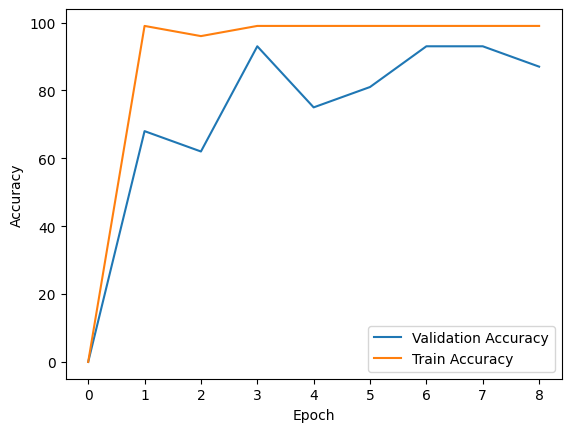

In [27]:
import matplotlib.pyplot as plt
#plot of accuracy graphs along whith number of epochs
plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix

# Get predicted and actual labels
predicted_labels = []
actual_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        if torch.cuda.is_available(): 
            images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
        actual_labels.extend(labels.tolist())

# Create confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Print confusion matrix
print(cm)

[[ 77 157]
 [  2 388]]


In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate f1 score, precision and recall
f1 = f1_score(actual_labels, predicted_labels, average='weighted')
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')

# Print results
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

F1 Score: 0.70
Precision: 0.81
Recall: 0.75
